## Erosion modeling
Resources:

* [
GRASS GIS overview and manual](http://grass.osgeo.org/grass74/manuals/index.html)
*  [Recommendations](data_acquisition.html#commands)
and [tutorial](./grass_intro.html)
how to use GUI from the first assignment
* [Brief theoretical background, equations, units](../resources/erosion_notes.pdf)
* [C-factor values](data/cfactor.txt)
* [K-factor](../resources/kfactor.html)
* [R-factor](https://www.ars.usda.gov/ARSUserFiles/64080530/RUSLE/AH_703.pdf) (page 47) 




Text files with recode rules and color rules:

* Land use category description ([lu_labels.txt](data/lu_labels.txt))
* C-factor recode table ([cfac_rules.txt](data/cfac_rules.txt))
* C-factor color table ([cfac_color.txt](data/cfac_color.txt))
* Soil loss color table ([soilloss_color.txt](data/soilloss_color.txt))
* Erosion/deposition color table ([erdep_color.txt](data/erdep_color.txt))
* Erosion/deposition classes ([erdep_class.txt](data/erdep_class.txt))
* Erosion/deposition class labels ([erdep_label.txt](data/erdep_label.txt))



### Start GRASS GIS
In startup pannel set GIS Data Directory to path to datasets,
for example on MS Windows, `C:\Users\myname\grassdata`.
For Project location select nc_spm_08_grass7 (North Carolina, State Plane, meters) and
for Accessible mapset create a new mapset (called e.g. HW_erosion) and
click Start GRASS.

In [1]:
# This is a quick introduction into Jupyter Notebook.
# Python code can be executed like this:
a = 6
b = 7
c = a * b
print "Answer is", c
# Python code can be mixed with command line code (Bash).
# It is enough just to prefix the command line with an exclamation mark:
!echo "Answer is $c"
# Use Shift+Enter to execute this cell. The result is below.

Answer is 42
Answer is 42


In [2]:
import os
import sys
import subprocess
from IPython.display import Image

# create GRASS GIS runtime environment
gisbase = subprocess.check_output(["grass", "--config", "path"]).strip()
os.environ['GISBASE'] = gisbase
sys.path.append(os.path.join(gisbase, "etc", "python"))

# do GRASS GIS imports
import grass.script as gs
import grass.script.setup as gsetup

# set GRASS GIS session data
rcfile = gsetup.init(gisbase, "/home/jovyan/grassdata", "nc_spm_08_grass7", "user1")

In [3]:
# default font displays
os.environ['GRASS_FONT'] = 'sans'
# overwrite existing maps
os.environ['GRASS_OVERWRITE'] = '1'
gs.set_raise_on_error(True)
gs.set_capture_stderr(True)

True

In [4]:
# set display modules to render into a file (named map.png by default)
os.environ['GRASS_RENDER_IMMEDIATE'] = 'cairo'
os.environ['GRASS_RENDER_FILE_READ'] = 'TRUE'
os.environ['GRASS_LEGEND_FILE'] = 'legend.txt'

Change working directory:
_Settings_ > _GRASS working environment_ > _Change working directory_ > select/create any directory
or type `cd` (stands for change directory) into the GUI
_Console_ and hit Enter:

In [5]:
# a proper directory is already set, download files
import urllib
urllib.urlretrieve("http://ncsu-geoforall-lab.github.io/geospatial-modeling-course/grass/data/cfactor.txt", "cfactor.txt")
urllib.urlretrieve("http://ncsu-geoforall-lab.github.io/geospatial-modeling-course/grass/data/lu_labels.txt", "lu_labels.txt")
urllib.urlretrieve("http://ncsu-geoforall-lab.github.io/geospatial-modeling-course/grass/data/cfac_rules.txt", "cfac_rules.txt")
urllib.urlretrieve("http://ncsu-geoforall-lab.github.io/geospatial-modeling-course/grass/data/cfac_color.txt", "cfac_color.txt")
urllib.urlretrieve("http://ncsu-geoforall-lab.github.io/geospatial-modeling-course/grass/data/soilloss_color.txt", "soilloss_color.txt")
urllib.urlretrieve("http://ncsu-geoforall-lab.github.io/geospatial-modeling-course/grass/data/erdep_color.txt", "erdep_color.txt")
urllib.urlretrieve("http://ncsu-geoforall-lab.github.io/geospatial-modeling-course/grass/data/erdep_class.txt", "erdep_class.txt")
urllib.urlretrieve("http://ncsu-geoforall-lab.github.io/geospatial-modeling-course/grass/data/erdep_label.txt", "erdep_label.txt")

('erdep_label.txt', <httplib.HTTPMessage instance at 0x7ff83a913830>)

Download all text files with recode rules, color rules and site locations (see above)
to the selected directory. Now you can use the commands from the assignment requiring the text file
without the need to specify the full path to the file.






### Compute soil detachment using USLE3D

#### Compute topographic potential (LS factor)

Compare impact of the power function exponents on the erosion pattern.
Which equation represents conditions when water flow has greater impact
and which models stronger influence of slope?

In [6]:
gs.parse_command('g.region', raster="elev_lid792_1m", flags='pg')
gs.run_command('r.slope.aspect', elevation="elev_lid792_1m", slope="slope_1m", aspect="aspect_1m")
gs.run_command('r.flow', elevation="elev_lid792_1m", flowaccumulation="flowacc_1m")
gs.mapcalc("lsfac3d_1m = 1.2 * pow(flowacc_1m * 1./22.1,0.2) * pow(sin(slope_1m)/0.09,1.3)")
gs.mapcalc("lsfac3d_s1_1m = 1.5 * pow(flowacc_1m * 1./22.1,0.5) * pow(sin(slope_1m)/0.09,1.0)")
gs.run_command('r.colors', map="lsfac3d_s1_1m", color="gyr", flags='e')
gs.run_command('r.colors', map="lsfac3d_1m", raster="lsfac3d_s1_1m")

0

Display layers and save outputs:
d.erase

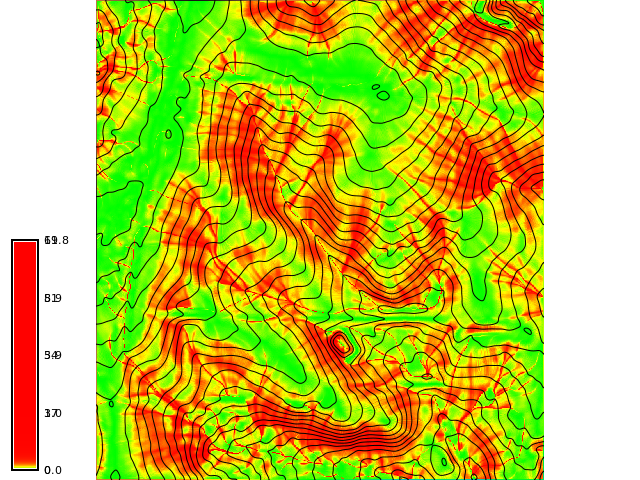

In [7]:
gs.run_command('d.rast', map="lsfac3d_1m")
gs.run_command('d.vect', map="elev_lid792_cont1m")
gs.run_command('d.legend', raster="lsfac3d_1m", at="2,50,2,6")
Image(filename="map.png")
gs.run_command('d.rast', map="lsfac3d_s1_1m")
gs.run_command('d.vect', map="elev_lid792_cont1m")
gs.run_command('d.legend', raster="lsfac3d_s1_1m", at="2,50,2,6")
Image(filename="map.png")

#### Compute soil detachment for spatially variable land cover

Set region to rural area and recode landcover_1m to cfactor
using the _r.recode_ module.
Assign special color table and display result.

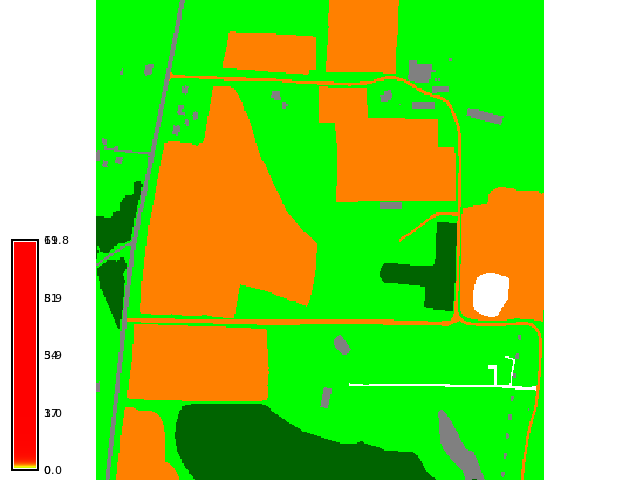

In [8]:
gs.parse_command('g.region', region="rural_1m", flags='pg')
gs.run_command('r.recode', input="landcover_1m", output="cfactor_1m", rules="cfac_rules.txt")
gs.run_command('r.colors', map="cfactor_1m", rules="cfac_color.txt")
gs.run_command('d.rast', map="cfactor_1m")
Image(filename="map.png")

Compute the USLE3D equation using map algebra,
cfactorbare_1m is the same as cfactor_1m,
cfactorgrow_1m has landuse recoded for summer conditions.
Specify units of the raster maps using
the _r.support_ module.
Compare erosion rates and distribution
for winter (bare) and summer conditions.

In [9]:
gs.mapcalc("soillossbare_1m = 270. * soils_Kfactor * lsfac3d_1m * cfactorbare_1m")
gs.mapcalc("soillossgrow_1m = 270. * soils_Kfactor * lsfac3d_1m * cfactorgrow_1m")
gs.run_command('r.colors', map="soillossbare_1m", rules="soilloss_color.txt")
gs.run_command('r.colors', map="soillossgrow_1m", raster="soillossbare_1m")
gs.run_command('r.support', map="soillossbare_1m", units="ton/(acre.year)")
gs.run_command('r.support', map="soillossgrow_1m", units="ton/(acre.year)")

0

d.erase
Remove previous layers and display the new ones:

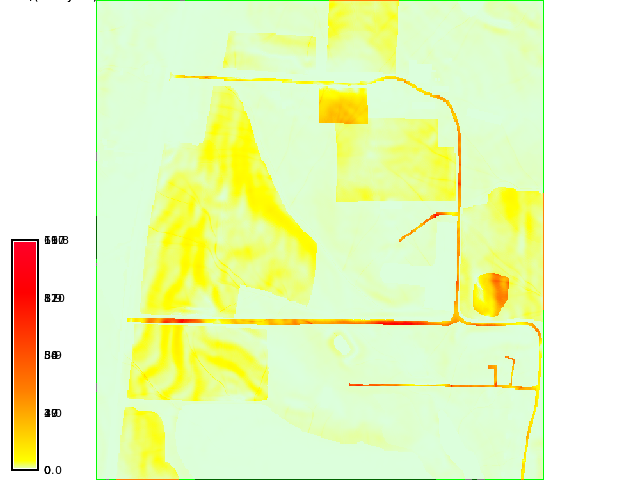

In [10]:
gs.run_command('d.rast', map="soillossbare_1m")
gs.run_command('d.legend', raster="soillossbare_1m", at="2,50,2,6")
Image(filename="map.png")
gs.run_command('d.rast', map="soillossgrow_1m")
gs.run_command('d.legend', raster="soillossgrow_1m", at="2,50,2,6")
Image(filename="map.png")
gs.parse_command('r.univar', map="soillossbare_1m", flags='g')
gs.parse_command('r.univar', map="soillossgrow_1m", flags='g')
Image(filename="map.png")

#### Compute new DEM with erosion carved-in

In [11]:
gs.mapcalc("elev_erodedb_1m = elev_lid792_1m-(soillossbare_1m/100.)")

Display elev_erodedb_1m in 3D and drape over soillossbare_1m as color.
To view it in 3D switch off everything except elev_erodedb_1m.
Drape soillossbare_1m as color and don't forget to set fine resolution to 1.
Use lighting from SW, z-exag at least 2.0


### Compute net erosion/deposition maps (using USPED)

Compute net erosion/deposition maps as divergence of sediment flow (USPED).

First compute sediment flow and its components in x, y directions:

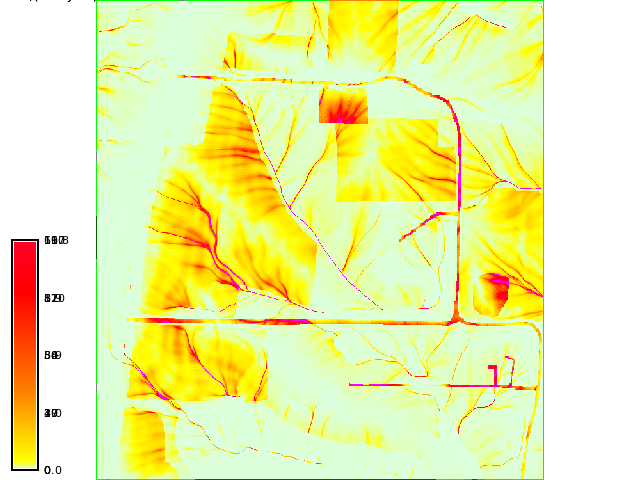

In [12]:
gs.mapcalc("sedflow_1m = 270. * soils_Kfactor * cfactorgrow_1m * flowacc_1m * sin(slope_1m)")
gs.run_command('r.colors', map="sedflow_1m", raster="soillossbare_1m")
gs.run_command('d.rast', map="sedflow_1m")
gs.mapcalc("qsx = sedflow_1m * cos(aspect_1m)")
gs.mapcalc("qsy = sedflow_1m * sin(aspect_1m)")
Image(filename="map.png")

Compute change of sediment flow in the x and y directions
and then change in the direction of flow using divergence.

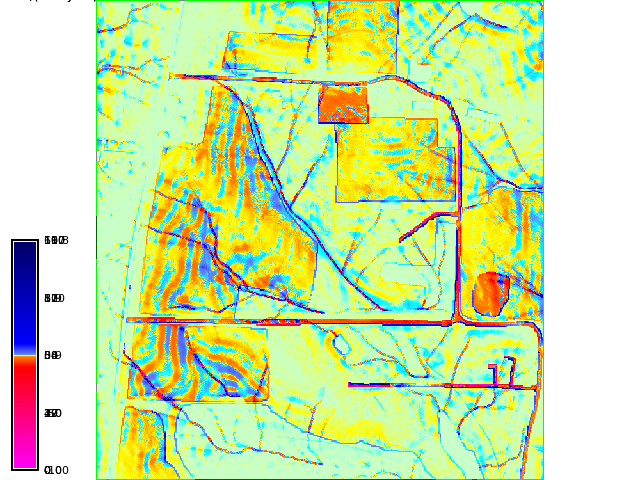

In [13]:
gs.run_command('r.slope.aspect', elevation="qsx", dx="qsx_dx")
gs.run_command('r.slope.aspect', elevation="qsy", dy="qsy_dy")
gs.mapcalc("erdep = qsx_dx + qsy_dy")
gs.parse_command('r.info', map="erdep", flags='rg')
gs.run_command('r.colors', map="erdep", rules="erdep_color.txt")
gs.run_command('d.rast', map="erdep")
gs.run_command('d.legend', raster="erdep", at="2,50,2,6", range="-100,100")
Image(filename="map.png")

Display elev_lid792_1m in 3D and drape over erdep as color (switch off all layers except for elev_lid792_1m).


#### Compute summary statistics

Use _r.recode_ to classify erosion/deposition and _r.category_
to add labels (stable, high erosion, etc) to individual categories:

In [14]:
gs.run_command('r.recode', input="erdep", output="erdep_class", rules="erdep_class.txt")
print gs.read_command('r.category', map="erdep_class", rules="erdep_label.txt", sep=":")
print gs.read_command('r.report', map="erdep_class", unit="p,h,a")


+-----------------------------------------------------------------------------+
|                         RASTER MAP CATEGORY REPORT                          |
|LOCATION: nc_spm_08_grass7                           Mon Jan  7 21:53:05 2019|
|-----------------------------------------------------------------------------|
|          north: 220750    east: 639000                                      |
|REGION    south: 220000    west: 638300                                      |
|          res:        1    res:       1                                      |
|-----------------------------------------------------------------------------|
|MASK: none                                                                   |
|-----------------------------------------------------------------------------|
|MAP: (untitled) (erdep_class in user1)                                       |
|-----------------------------------------------------------------------------|
|             Category Information     

Example output:
```
[...]
| #| description         |  %  | hectares |  acres  |
|-4| severe erosion . . .| 0.19|  0.101300|  0.25031|
|-3| high erosion . . . .| 1.34|  0.701600|  1.73365|
|-2| moderate erosion . .| 3.89|  2.042600|  5.04726|
|-1| low erosion . . . . |19.74| 10.366000| 25.61438|
| 0| stable . . . . . . .|61.32| 32.192000| 79.54643|
| 1| low deposition . . .| 8.40|  4.407600| 10.89118|
| 2| moderate deposition | 2.49|  1.307500|  3.23083|
| 3| high deposition . . | 1.29|  0.676900|  1.67262|
| 4| severe deposition . | 0.24|  0.126100|  0.31159|
| *|no data. . . . . . . | 1.10|  0.578400|  1.42922|
|---------------------------------------------------|
|TOTAL                   |100.00| 52.500000|129.7275|
```

Comment on advantages, disadvantages and risks of
classifying erosion/deposition data into categories.


Compute univariate statistics:

In [15]:
gs.parse_command('r.univar', map="erdep", flags='g')

{u'cells': u'525000',
 u'coeff_var': u'-243055.304632725',
 u'max': u'1233.67712402344',
 u'mean': u'-0.00457319076008614',
 u'mean_of_abs': u'1.13868654031229',
 u'min': u'-1112.02917480469',
 u'n': u'519216',
 u'null_cells': u'5784',
 u'range': u'2345.70629882812',
 u'stddev': u'11.115382733363',
 u'sum': u'-2374.47381368889',
 u'variance': u'123.551733309144'}

Look for line with sum:

```
sum: -2374.473814
```


The units are tons/(acre.year), but our cells are 1 m2.
Therefore we have to divide by 4046 (1 acre = 4046 m2)
to get total ton per year transported from the watershed.
You can use the Python shell in the _Python_ tab do the division.

In [16]:
# end the GRASS session
os.remove(rcfile)